#### Early global pathfinding

Idea:
- Use A* to find a path for the reactive agent to follow. 
- Collision avoidance along the path. 
    - Generate a path, and **order** it.
    - When following, choose the foremost section of the path, within a certain distance to go towards.

- How to get map? Make into matrix, and dilate all values with heavy cost values to avoid going through obstacles.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('classic')

In [2]:
from visualization import *

# TODO: litt bakvendt å bruke pygame.surface til å generere surface, lagre som jpeg og så gjøre til matrix...


MAP_DIMENSIONS = (1080, 1920)
gfx = Visualization(MAP_DIMENSIONS, pixels_per_unit=10, map_img_path="graphics/test_map_2.png") # Also initializes the display

# Spawn in the walls:
vertices = np.array([[5, 5], [5, 105], [180, 105], [180, 5]])
wall1 = Object(np.array([0, 0]), vertices=vertices)
vertices = np.array([[20, 20], [20, 105//2], [180//2, 105//2], [180//2, 20]])
wall2 = Object(np.array([0, 0]), vertices=vertices)
vertices = np.array([[20, 105//2 + 20], [20, 105-10], [180//2, 105-10], [180//2, 105//2+20]])
wall3 = Object(np.array([0, 0]), vertices=vertices)
vertices = np.array([[180//2 + 20, 20], [180//2 + 20, 105//2], [180-20, 105//2], [180-20, 20]])
wall4 = Object(np.array([0, 0]), vertices=vertices)
vertices = np.array([[180//2 + 20, 105//2+20], [180//2 + 20, 105-10], [180-20, 105-10], [180-20, 105//2+20]])
wall5 = Object(np.array([0, 0]), vertices=vertices)
# Extra obstacles
vertices = np.array([[70, 105//2], [70, 105//2+20], [80, 105//2+20], [80, 105//2]])
wall6 = Object(np.array([0, 0]), vertices=vertices)
vertices = np.array([[180//2, 90], [180//2+20, 90], [180//2+20, 80], [180//2, 80]])
wall7 = Object(np.array([0, 0]), vertices=vertices)
vertices = np.array([[40, 5], [40, 20], [45, 20], [45, 5]])
wall8 = Object(np.array([0, 0]), vertices=vertices)
vertices = np.array([[160, 5], [160, 20], [155, 20], [155, 5]])
wall9 = Object(np.array([0, 0]), vertices=vertices)

objects = [wall1, wall2, wall3, wall4, wall5, wall6, wall7, wall8, wall9]#, wall10]


gfx.clear_canvas()
gfx.draw_all_objects(objects)
print(gfx.map)
pygame.image.save(gfx.map, "graphics/current_map.jpeg")

pygame 2.1.0 (SDL 2.0.16, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
<Surface(1920x1080x32 SW)>


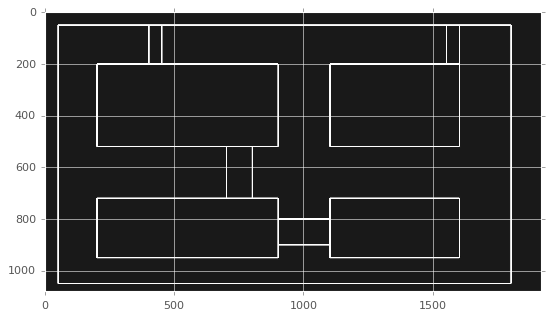

In [3]:
map = cv2.imread("graphics/current_map.jpeg", cv2.IMREAD_GRAYSCALE)
map = (255-map)

#for c in range(1080):
#    for r in range(1920):
#        if map[c, r] < 100:
#            map[c, r] = 1 # Cost
#        else: 
#            map[c, r] = 255 # Cost
plt.imshow(map, cmap="gray");

***Add dilation***

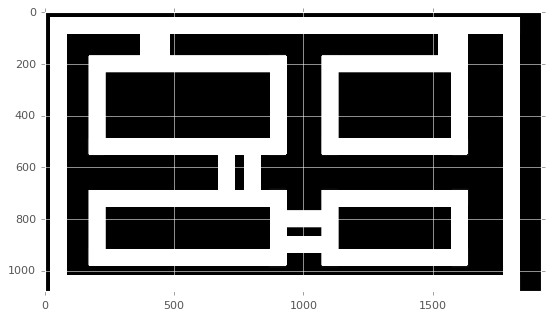

In [4]:
dilated = cv2.dilate(map, None, iterations=30)
plt.imshow(dilated, cmap="gray");

***Might want to resize the image before A***

(54, 96)


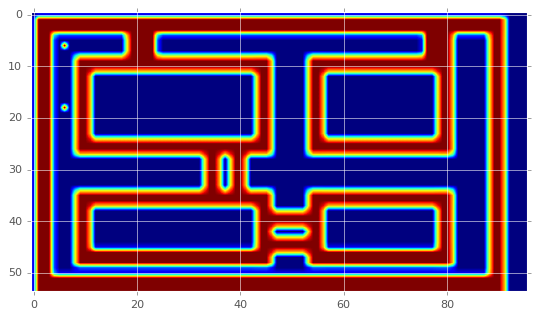

In [5]:
scale_percent = 5 # percent of original size
width = int(dilated.shape[1] * scale_percent / 100)
height = int(dilated.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
resized = cv2.resize(dilated, dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized)
print(resized.shape)

# Starting locations
marked = np.copy(resized)
marked[6, 6] = 255 # Start
marked[18, 6] = 255 # Fin
plt.imshow(marked);

### A* search

In [6]:
def h(point1, point2):
    return np.linalg.norm(point1 - point2)

In [7]:
"""A* algorithm and some problems to be solved by it.
I used the pseudo-code of 'Essentials of the A* algorithm' published on blackboard"""
__author__ = "Henrik Fjellheim"

class Node:
    """A search node, in this case representing a position on a board. They have parents and children"""
    def __init__(self, best_parent=None, position=None):
        """
        Initialize the node. Nodes are born without parents. The optimal parent is added later: like adoption
        :param position: is the x and y coordinate of the node
        """
        self.position = position
        self.children = []
        self.best_parent = best_parent
        self.g = 0
        self.h = 0

    def get_f(self):
        """Estimate total cost of solution path through this node"""
        return self.g + self.h

    def __eq__(self, other):
        """We overload eq so that we can compare two nodes"""
        return self.position == other.position

    def __gt__(self, other):
        """We overload gt so that we can sort the list based on f - value"""
        return self.get_f() > other.get_f()

    def __str__(self):
        return "|Position: " + str(self.position) + " f-value: " + str(self.get_f()) + "| "


def a_star(board, start, end):
    """
    Algorithm based on the 'essentials of A* pseudo-code'
    :param board: an integer double list of the maze. first index is x - , second is y - coordinates
    :param start: starting position as a list of two elements [x, y]
    :param end: goal position as a list of two elements [x, y]
    :return: A list og tuple-coordinates, describing the optimal path found
    """
    # Initiate
    closed_nodes = []
    open_nodes = []
    start_node = Node(None, start)
    start_node.h = heuristic_function(start_node.position, end)
    open_nodes.append(start_node)

    end_node = Node(None, end)

    while open_nodes:
        """
        print("[", end='')
        for n in open_nodes:
            print(str(n)+", ", end='')
        print("]")
        """
        current_node = open_nodes.pop(0)
        closed_nodes.append(current_node)

        # Found goal, re-tracking to find path returns path as list of positions
        if current_node == end_node:
            print("endgame")
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.best_parent
            return path[::-1]  # Returns path in reverse

        # Generate children, they can be north, south, east or west of the parent
        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
            # For moving diagonally [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            # It's a wall, cannot walk here
            if board[node_position[0]][node_position[1]] == 255:
                continue

            # Create new child in this new position
            new_node = Node(current_node, node_position)
            children.append(new_node)

        # Adds the child to the parents child-list
        for child in children:
            # The tile cost is the g cost of the current child, it is found on the board
            tile_cost = board[child.position[0]][child.position[1]]

            # Checks if the child has previously been created, and therefor is either in open or closed nodes
            # if it is, we rather look at the old version and update it
            for i in range(len(open_nodes)):
                if open_nodes[i] == child:
                    child = open_nodes[i]
            for j in range(len(closed_nodes)):
                if closed_nodes[j] == child:
                    child = closed_nodes[j]

            # appending the correct node to children list
            current_node.children.append(child)

            if child not in open_nodes and child not in closed_nodes:
                # It has not yet been evaluated, and we don't need to propagate it
                attach_and_eval(child, current_node, end, tile_cost)
                open_nodes.append(child)
                open_nodes.sort()

            elif current_node.g + tile_cost < child.g:  # (found cheaper path to the child):
                # ∗ attach-and-eval(S,X)
                # ∗ If S ∈ CLOSED then propagate-path-improvements(S)
                attach_and_eval(child, current_node, end, tile_cost)
                if child in closed_nodes:
                    propagate_path_improvements(child)

    return False    # FAIL


def heuristic_function(node, goal):
    """Uses manhattan distance to calculate; it ignores walls and is therefor admissible"""
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])


def attach_and_eval(child, parent, end, tile_cost):
    """Attaches a node to its best parent (so far)
    the child's g'value is computed based on parent, h independently"""
    child.best_parent = parent
    child.g = parent.g + tile_cost
    child.h = heuristic_function(child.position, end)


def propagate_path_improvements(parent):
    """Goes through the children and possibly many other decedents
    If parent is no longer their best parent, the propagation ceases,
    if any child can have parent as its best parent it must be updated
    and propagated further to the children of the children"""
    for child in parent.children:
        if parent.g + 1 < child.g:
            child.best_parent = parent
            child.g = parent.g + 1
            propagate_path_improvements(child)


def draw_path(board, path):
    for t in path:
        board.set_cell_value(t, " Ø ", True)



In [11]:
path = a_star(resized, (6, 6), (6, 26))

endgame


: 

### Visualize path

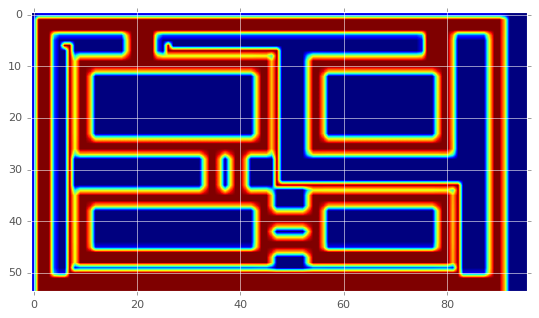

In [9]:
path_on_map = np.copy(resized)
for step in path:
    path_on_map[step[0], step[1]] = 255

plt.imshow(path_on_map)

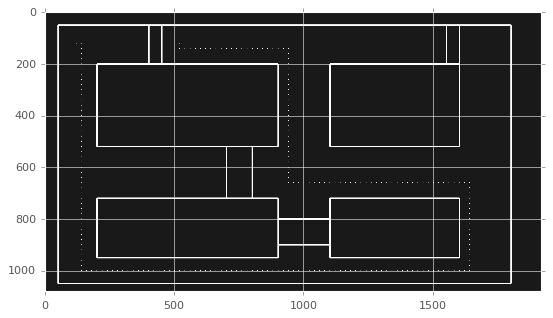

In [10]:
path_resized = np.array(path)*20 # Scale back up
path_on_map = np.copy(map)
for step in path_resized:
    # Center
    path_on_map[step[0], step[1]] = 255
    # Also add some "girth"
    path_on_map[step[0]+1, step[1]] = 255
    path_on_map[step[0], step[1]+1] = 255
    path_on_map[step[0]+1, step[1]+1] = 255
    path_on_map[step[0]-1, step[1]] = 255
    path_on_map[step[0], step[1]-1] = 255
    path_on_map[step[0]-1, step[1]-1] = 255
    path_on_map[step[0]+1, step[1]-1] = 255

plt.imshow(path_on_map, cmap="gray");